<a href="https://colab.research.google.com/github/escoso4594/TE8309/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd	
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Load the source data file
df = pd.read_excel (r'/content/Data for time series.xlsx')
print (df)

                     time   O3   NO2  PM25
0     2019-01-01 00:00:00  6.0  53.0  56.0
1     2019-01-01 01:00:00  6.0  52.0  54.0
2     2019-01-01 02:00:00  5.0  46.0  55.0
3     2019-01-01 03:00:00  5.0  50.0  52.0
4     2019-01-01 04:00:00  NaN  51.0  48.0
...                   ...  ...   ...   ...
8602  2019-12-31 19:00:00  2.0  57.0  43.0
8603  2019-12-31 20:00:00  2.0  64.0  45.0
8604  2019-12-31 21:00:00  2.0  68.0  48.0
8605  2019-12-31 22:00:00  2.0  67.0  54.0
8606  2019-12-31 23:00:00  2.0  68.0  47.0

[8607 rows x 4 columns]


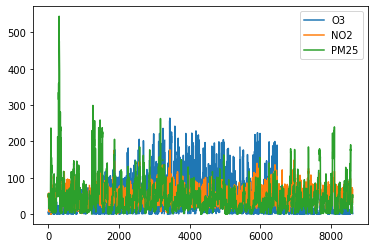

In [3]:
df.plot()
plt.show()

1. ANALYSIS FOR OZONE CONCENTRATION

1.1 AUTOCORRELATION AND PARTIAL AUTOCORRELATION IN ORIGINAL DATA SET

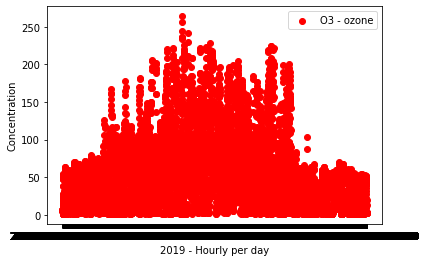

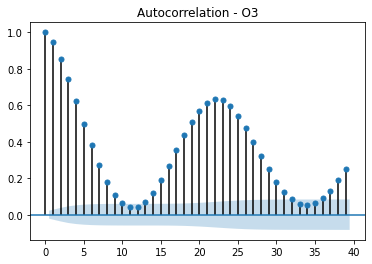

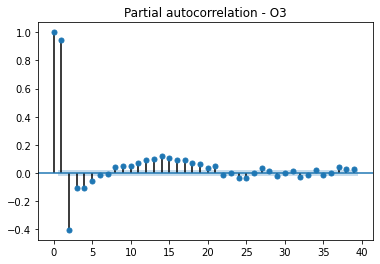

Durbin Watson Test: [0.05036148]


In [37]:
#Create scatter plot to discover the trend of ozone along the year
x=df.time
y=df.O3
plt.scatter(x,y, label='O3 - ozone', color='r')
plt.legend()
plt.xlabel("2019 - Hourly per day")
plt.ylabel("Concentration")
plt.show()
#Autocorrelation and partial autocorrelation test on ozone sub dataframe
df_O3=df.drop(columns=['time','NO2', 'PM25'])
df_O3.dropna(inplace=True)
plot_acf(df_O3)
plt.title("Autocorrelation - O3")
plt.show()
plot_pacf(df_O3)
plt.title("Partial autocorrelation - O3")
plt.show()
#perform Durbin-Watson test to assess autocorrelation
durbinwatson = durbin_watson(df_O3)
print('Durbin Watson Test:',durbinwatson)


1.2 STATIONARITY

In [38]:
#Evaluate stationarity for ozone sub dataframe
#Getting the count to split the dataset into ranges of 4 months to represent seasons
values = df_O3.values
values1 = df_O3.iloc[:,0].values
result = adfuller(values1)
parts = int(len(values)/4)
part_1, part_2, part_3, part_4= values[0:parts], values[parts:(parts*2)], values[(parts*2):(parts*3)], values[(parts*3):(parts*4)]
mean_1, mean_2, mean_3, mean_4 = part_1.mean(), part_2.mean(), part_3.mean(), part_4.mean()
var_1, var_2, var_3, var_4 = part_1.var(), part_2.var(), part_3.var(), part_4.var()
print('Statistical properties from original dataframe:')
print('a) mean1=%f, mean2=%f, mean3=%f, mean4=%f' % (mean_1, mean_2, mean_3, mean_4))
print('b) variance1=%f, variance2=%f, variance3=%f, variance4=%f' % (var_1, var_2, var_3, var_4))
print('c) Dicky-Fuller test:')
print('    p-value: ', result[1],',  ADF Statistic: %f' % result[0])

Statistical properties from original dataframe:
a) mean1=38.206048, mean2=80.982060, mean3=70.579190, mean4=19.801128
b) variance1=1124.809415, variance2=2913.193425, variance3=2817.243216, variance4=480.644202
c) Dicky-Fuller test:
    p-value:  5.146584899135252e-09 ,  ADF Statistic: -6.650104


1.3 ARIMA MODELING

In [39]:
#ARIMA model results
sarimax_model = SARIMAX(values, order=(2,1,2))
model = sarimax_model.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 7807
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -31710.896
Date:                Thu, 28 Apr 2022   AIC                          63431.792
Time:                        21:04:32   BIC                          63466.605
Sample:                             0   HQIC                         63443.723
                               - 7807                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8359      0.006    323.675      0.000       1.825       1.847
ar.L2         -0.9098      0.005   -169.839      0.000      -0.920      -0.899
ma.L1         -1.7179      0.008   -205.755      0.0

1.4 FORECAST

In [41]:
#Creating forecast set for the next 164 values (1 week)
df_O3_forecast = df_O3
df_O3_temp = pd.DataFrame(columns=['O3'])
i = 0
for i in range (164):  
  forecast = model.forecast(steps=i+1)[i]
  df_O3_temp.loc[len(df_O3_temp)] = forecast
  i = i+1
df_O3_forecast = df_O3_forecast.append(df_O3_temp, ignore_index=True)
print(df_O3_forecast)

             O3
0      6.000000
1      6.000000
2      5.000000
3      5.000000
4      1.000000
...         ...
7966  13.787067
7967  13.788671
7968  13.790451
7969  13.792260
7970  13.793960

[7971 rows x 1 columns]


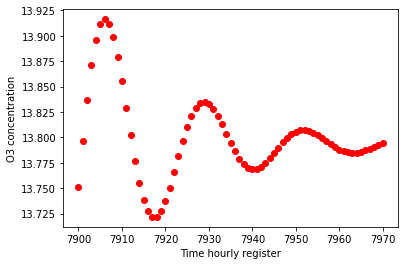

In [43]:
#Plot the tail of the original data set and the new forecast curve
x=df_O3_forecast.index[7900:]
y=df_O3_forecast.O3[7900:]
plt.scatter(x,y,color='r')
plt.xlabel("Time hourly register")
plt.ylabel("O3 concentration")
plt.show()

2. ANALYSIS FOR NITROGEN DIOXIDE

2.1 AUTOCORRELATION AND PARTIAL AUTOCORRELATION IN ORIGINAL DATA SET

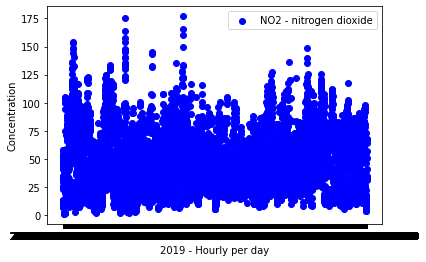

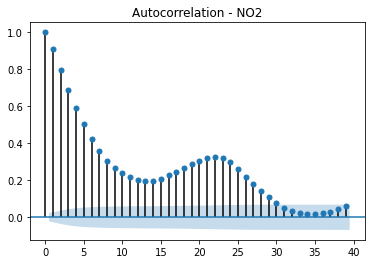

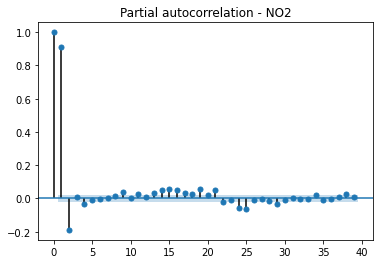

Durbin Watson Test: [0.04155551]


In [44]:
#Create scatter plot to discover the trend of nitrogen dioxide along the year
x=df.time
y=df.NO2
plt.scatter(x,y, label='NO2 - nitrogen dioxide', color='b')
plt.legend()
plt.xlabel("2019 - Hourly per day")
plt.ylabel("Concentration")
plt.show()
#Autocorrelation and partial autocorrelation test on nitrogen dioxide sub dataframe
df_NO2=df.drop(columns=['time','O3', 'PM25'])
df_NO2.dropna(inplace=True)
plot_acf(df_NO2)
plt.title("Autocorrelation - NO2")
plt.show()
plot_pacf(df_NO2)
plt.title("Partial autocorrelation - NO2")
plt.show()
#perform Durbin-Watson test to assess autocorrelation
durbinwatson = durbin_watson(df_NO2)
print('Durbin Watson Test:',durbinwatson)

2.2 STATIONARITY

In [45]:
#Evaluate stationarity for nitrogen dioxide sub dataframe
#Getting the count to split the dataset into ranges of 4 months to represent seasons
values = df_NO2.values
values1 = df_NO2.iloc[:,0].values
result = adfuller(values1)
parts = int(len(values)/4)
part_1, part_2, part_3, part_4= values[0:parts], values[parts:(parts*2)], values[(parts*2):(parts*3)], values[(parts*3):(parts*4)]
mean_1, mean_2, mean_3, mean_4 = part_1.mean(), part_2.mean(), part_3.mean(), part_4.mean()
var_1, var_2, var_3, var_4 = part_1.var(), part_2.var(), part_3.var(), part_4.var()
print('Statistical properties from original dataframe:')
print('a) mean1=%f, mean2=%f, mean3=%f, mean4=%f' % (mean_1, mean_2, mean_3, mean_4))
print('b) variance1=%f, variance2=%f, variance3=%f, variance4=%f' % (var_1, var_2, var_3, var_4))
print('c) Dicky-Fuller test:')
print('    p-value: ', result[1],',  ADF Statistic: %f' % result[0])

Statistical properties from original dataframe:
a) mean1=49.661199, mean2=44.094823, mean3=44.012301, mean4=55.518196
b) variance1=1065.716583, variance2=564.097108, variance3=458.404769, variance4=621.322965
c) Dicky-Fuller test:
    p-value:  5.827217004736574e-22 ,  ADF Statistic: -11.892395


2.3 ARIMA MODELING



In [46]:
#ARIMA model results
sarimax_model = SARIMAX(values, order=(2,1,2))
model = sarimax_model.fit()
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 7807
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -29630.193
Date:                Thu, 28 Apr 2022   AIC                          59270.386
Time:                        21:07:50   BIC                          59305.199
Sample:                             0   HQIC                         59282.317
                               - 7807                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0553      0.046     22.802      0.000       0.965       1.146
ar.L2         -0.1709      0.043     -4.014      0.000      -0.254      -0.087
ma.L1         -0.9732      0.047    -20.707      0.0

2.4 FORECAST

In [49]:
#Creating forecast set for the next 48 values (2 days)
df_NO2_forecast = df_NO2
df_NO2_temp = pd.DataFrame(columns=['NO2'])
i = 0
for i in range (48):  
  forecast = model.forecast(steps=i+1)[i]
  df_NO2_temp.loc[len(df_NO2_temp)] = forecast
  i = i+1
df_NO2_forecast = df_NO2_forecast.append(df_NO2_temp, ignore_index=True)
print(df_NO2_forecast)

            NO2
0     53.000000
1     52.000000
2     46.000000
3     50.000000
4     50.000000
...         ...
7850  54.091078
7851  54.088828
7852  54.086903
7853  54.085257
7854  54.083848

[7855 rows x 1 columns]


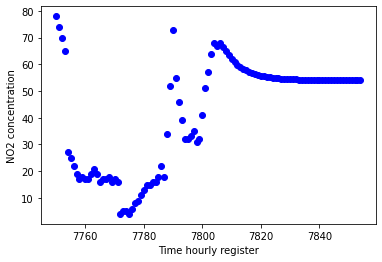

In [57]:
#Plot the tail of the original data set and the new forecast curve
x=df_NO2_forecast.index[7750:]
y=df_NO2_forecast.NO2[7750:]
plt.scatter(x,y,color='b')
plt.xlabel("Time hourly register")
plt.ylabel("NO2 concentration")
plt.show()

3. ANALYSIS OF PARTICLE MATTER 2.5

3.1 AUTOCORRELATION AND PARTIAL AUTOCORRELATION IN ORIGINAL DATA SET

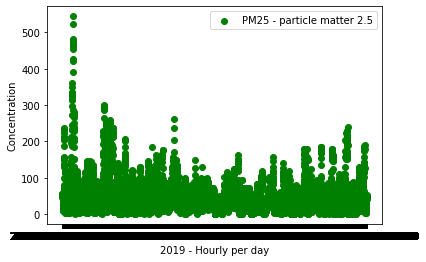

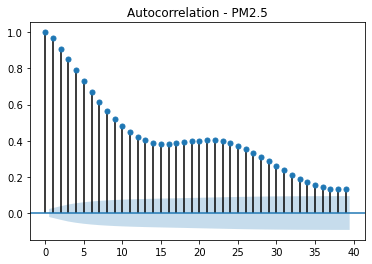

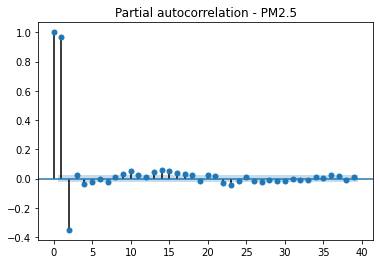

Durbin Watson Test: [0.03325836]


In [58]:
#Create scatter plot to discover the trend of particle matter 2.5 along the year
x=df.time
y=df.PM25
plt.scatter(x,y, label='PM25 - particle matter 2.5', color='g')
plt.legend()
plt.xlabel("2019 - Hourly per day")
plt.ylabel("Concentration")
plt.show()
#Autocorrelation and partial autocorrelation test on particle matter 2.5 sub dataframe
df_PM25=df.drop(columns=['time','O3', 'NO2'])
df_PM25.dropna(inplace=True)
plot_acf(df_PM25)
plt.title("Autocorrelation - PM2.5")
plt.show()
plot_pacf(df_PM25)
plt.title("Partial autocorrelation - PM2.5")
plt.show()
#perform Durbin-Watson test to assess autocorrelation
durbinwatson = durbin_watson(df_PM25)
print('Durbin Watson Test:',durbinwatson)

3.2 STATIONARITY

In [59]:
#Evaluate stationarity for particle matter 2.5 sub dataframe
#Getting the count to split the dataset into ranges of 4 months to represent seasons
values = df_PM25.values
values1 = df_PM25.iloc[:,0].values
result = adfuller(values1)
parts = int(len(values)/4)
part_1, part_2, part_3, part_4= values[0:parts], values[parts:(parts*2)], values[(parts*2):(parts*3)], values[(parts*3):(parts*4)]
mean_1, mean_2, mean_3, mean_4 = part_1.mean(), part_2.mean(), part_3.mean(), part_4.mean()
var_1, var_2, var_3, var_4 = part_1.var(), part_2.var(), part_3.var(), part_4.var()
print('Statistical properties from original dataframe:')
print('a) mean1=%f, mean2=%f, mean3=%f, mean4=%f' % (mean_1, mean_2, mean_3, mean_4))
print('b) variance1=%f, variance2=%f, variance3=%f, variance4=%f' % (var_1, var_2, var_3, var_4))
print('c) Dicky-Fuller test:')
print('    p-value: ', result[1],',  ADF Statistic: %f' % result[0])

Statistical properties from original dataframe:
a) mean1=60.354177, mean2=48.230138, mean3=35.672476, mean4=46.701179
b) variance1=4700.159028, variance2=1023.371434, variance3=712.160795, variance4=1940.259758
c) Dicky-Fuller test:
    p-value:  2.757391031733585e-18 ,  ADF Statistic: -10.336354


3.3 ARIMA MODELING

In [62]:
#ARIMA model results
sarimax_model = SARIMAX(values, order=(2,1,2))
model = sarimax_model.fit()
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 7807
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -30126.001
Date:                Thu, 28 Apr 2022   AIC                          60262.003
Time:                        21:15:30   BIC                          60296.816
Sample:                             0   HQIC                         60273.934
                               - 7807                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1678      2.604      0.064      0.949      -4.936       5.272
ar.L2         -0.0082      0.452     -0.018      0.985      -0.895       0.878
ma.L1          0.1780      2.604      0.068      0.9

3.4 FORECAST

In [68]:
#Creating forecast set for the next 6 values (6 hours)
df_PM25_forecast = df_PM25
df_PM25_temp = pd.DataFrame(columns=['PM25'])
i = 0
for i in range (6):  
  forecast = model.forecast(steps=i+1)[i]
  df_PM25_temp.loc[len(df_PM25_temp)] = forecast
  i = i+1
df_PM25_forecast = df_PM25_forecast.append(df_PM25_temp, ignore_index=True)
print(df_PM25_forecast)

           PM25
0     56.000000
1     54.000000
2     55.000000
3     52.000000
4     50.000000
...         ...
7808  43.744557
7809  43.683645
7810  43.677531
7811  43.677007
7812  43.676969

[7813 rows x 1 columns]


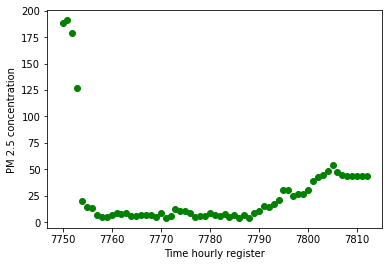

In [72]:
#Plot the tail of the original data set and the new forecast curve
x=df_PM25_forecast.index[7750:]
y=df_PM25_forecast.PM25[7750:]
plt.scatter(x,y,color='g')
plt.xlabel("Time hourly register")
plt.ylabel("PM 2.5 concentration")
plt.show()